In [1]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor

In [155]:
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.recurrent import LSTM
from keras.layers import Merge, Input, concatenate, GaussianNoise
from keras.layers import LeakyReLU
from keras.layers import Bidirectional

Using TensorFlow backend.


In [288]:
%matplotlib inline

In [278]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:10000], data[10000:15000]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/20))
	test = array(split(test, len(test)/20))
    # reshape the data
#	train = train.reshape(train.shape[0],1,train.shape[1])
#	test = test.reshape(test.shape[0],1,test.shape[1])
	return train, test

In [3]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [4]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [172]:
def LSTMRegressor():
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(10, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics =['accuracy'])
    
    return model

In [273]:
# prepare a list of ml models
def get_models(models=dict()):
	# linear models
#	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
#	models['en'] = ElasticNet()
#	models['huber'] = HuberRegressor()
#	models['lars'] = Lars()
#	models['llars'] = LassoLars()
#	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
#	models['ranscac'] = RANSACRegressor()
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
#	models['lstm'] = LSTMRegressor()
	print('Defined %d models' % len(models))
	return models

In [235]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
#	steps.append(('standardize', StandardScaler()))
	# normalization
#	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

In [254]:
# make a recursive multi-step forecast
def forecast(model, input_x, n_input):
	yhat_sequence = list()
	input_data = [x for x in input_x]
	for j in range(20):
		# prepare the input data
		X = array(input_data[-n_input:]).reshape(1, n_input)
		# make a one-step forecast
		yhat = model.predict(X)[0]
		# add to the result
		yhat_sequence.append(yhat)
		# add the prediction to the input
		input_data.append(yhat)
	return yhat_sequence

In [237]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:] for week in data]
	# flatten into a single series
	series = array(series).flatten()
#	series = series.reshape(series.shape[0],1,series.shape[1])
	return series

In [238]:
# convert history into inputs and outputs
def to_supervised(history, n_input):
	# convert history to a univariate series
	data = to_series(history)
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(data)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		# ensure we have enough data for this instance
		if ix_end < len(data):
			X.append(data[ix_start:ix_end])
			y.append(data[ix_end])
		# move along one time step
		ix_start += 1
	return array(X), array(y)

In [239]:
# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
	# prepare data
	train_x, train_y = to_supervised(history, n_input)
	# make pipeline
	pipeline = make_pipeline(model)
	# fit the model
#	print(model)
#	if str(model).find('keras'):
#		print('Keras')
#		train_x = train_x.reshape(train_x.shape[0],1,train_x.shape[1])
#		train_y = train_y.reshape(train_y.shape[0],1,1)
#		pipeline.fit(train_x, train_y)
		# predict the week, recursively
#		yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
#		return yhat_sequence
        
	pipeline.fit(train_x, train_y)
	# predict the week, recursively
	yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
	return yhat_sequence

In [240]:
# evaluate a single model
def evaluate_model(model, train, test, n_input):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = sklearn_predict(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :], predictions)
	return score, scores, predictions

In [241]:
# load the new file

In [242]:
dataset = read_csv('trainData_set1.csv')

In [260]:
# extracting a single feature
X0 = dataset.BIDASKIMBALANCE

In [279]:
# split into train and test
train, test = split_dataset(X0.values)

In [280]:
# prepare the models to evaluate
models = get_models()
n_input = 60

Defined 3 models


lasso: [0.360] 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4
ridge: [0.174] 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2
sgd: [0.178] 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2


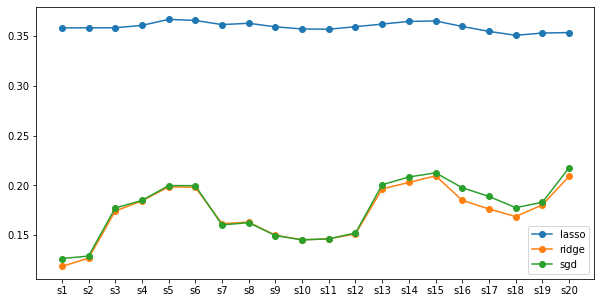

In [281]:
pyplot.figure(figsize=(10,5))
# evaluate each model
days = ['s1', 's2', 's3', 's4', 's5', 's6', 's7','s8','s9','s10','s11', 's12', 's13', 's14', 's15', 's16', 's17','s18','s19','s20']
for name, model in models.items():
	# evaluate and get scores
	score, scores, predictions = evaluate_model(model, train, test, n_input)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot

pyplot.legend()
pyplot.show()

In [75]:
# history is a list of weekly data
history = [x for x in train]

In [77]:
history[0]

array([ 0.81842496,  0.80010296,  0.79983822,  0.80248914, -0.28873649,
       -0.32236988, -0.32250118, -0.32257618, -0.32351234, -0.53574292])

In [108]:
yhat_sequence = sklearn_predict(model, history, n_input)

In [110]:
yhat_sequence

[0.48656085608601907,
 0.4785101079800522,
 0.47411424587959283,
 0.4700412189608807,
 0.45645532817719814,
 0.44582414292849726,
 0.436746676630281,
 0.42817939460283383,
 0.42001079160127675,
 0.4122592398129905]

In [282]:
predictions.shape

(250, 20)

In [283]:
import pandas as pd

In [284]:
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

In [285]:
predictionDF = pd.DataFrame(data=predictions, columns=['s1', 's2', 's3', 's4', 's5', 's6', 's7',
                                                       's8','s9','s10','s11', 's12', 's13', 's14', 's15',
                                                       's16', 's17','s18','s19','s20'])

In [286]:
predictionDF.describe()

s1          s2          s3          s4          s5          s6  \
count  250.000000  250.000000  250.000000  250.000000  250.000000  250.000000   
mean     0.067742    0.066860    0.066053    0.065484    0.064876    0.065195   
std      0.335423    0.329379    0.324221    0.320140    0.316254    0.313386   
min     -0.928654   -0.922563   -0.917271   -0.913082   -0.909508   -0.906484   
25%     -0.206727   -0.203786   -0.200994   -0.199244   -0.197839   -0.196437   
50%      0.069811    0.069548    0.070066    0.069751    0.069998    0.070725   
75%      0.262880    0.260157    0.254942    0.254922    0.253306    0.249804   
max      0.929365    0.909659    0.909293    0.908813    0.910601    0.907864   

               s7          s8          s9         s10         s11         s12  \
count  250.000000  250.000000  250.000000  250.000000  250.000000  250.000000   
mean     0.064859    0.064086    0.062993    0.061429    0.059707    0.059584   
std      0.309435    0.305595    0.301781    0.298307    0.294240    0.291597   
min     -0.903254   -0.899823   -0.896717   -0.893540   -0.891053   -0.889132   
25%     -0.192463   -0.188416   -0.184981   -0.181994   -0.179035   -0.175660   
50%      0.070018    0.066662    0.067304    0.066522    0.067102    0.065577   
75%      0.245525    0.237714    0.233975    0.232491    0.222934    0.220062   
max      0.901877    0.893525    0.882956    0.873894    0.866321    0.869150   

              s13         s14         s15         s16         s17         s18  \
count  250.000000  250.000000  250.000000  250.000000  250.000000  250.000000   
mean     0.058205    0.057947    0.056665    0.055562    0.054961    0.054537   
std      0.288647    0.286268    0.283747    0.281233    0.278994    0.277004   
min     -0.887260   -0.885529   -0.883828   -0.882735   -0.881935   -0.881218   
25%     -0.170468   -0.165447   -0.167640   -0.164833   -0.155979   -0.155286   
50%      0.063088    0.063060    0.062310    0.061085    0.060675    0.060722   
75%      0.217779    0.216737    0.215458    0.213681    0.208739    0.202425   
max      0.873999    0.882836    0.887335    0.897328    0.903206    0.901660   

              s19         s20  
count  250.000000  250.000000  
mean     0.054233    0.053999  
std      0.275254    0.273540  
min     -0.880321   -0.879612  
25%     -0.154342   -0.152622  
50%      0.059908    0.061429  
75%      0.197727    0.195427  
max      0.906822    0.903034

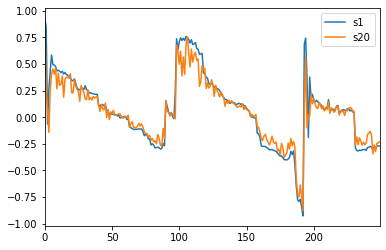

In [292]:
predictionDF[['s1','s20']].plot();

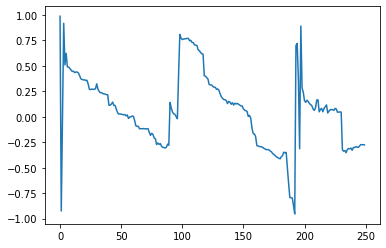

In [291]:
pyplot.plot(test[:, 0]);

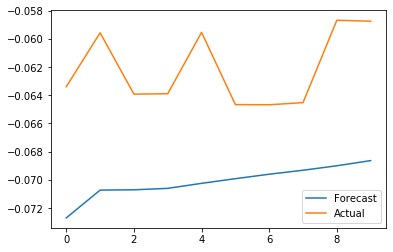

In [247]:
x = 7
#pyplot.plot(predictions[0,:])
pyplot.plot(predictions[x,:], label='Forecast')
pyplot.plot(test[x,:], label='Actual')
pyplot.legend()
pyplot.show()

In [159]:
train_x.shape

(26180, 10)

In [160]:
train1 = train.reshape(train.shape[0],1,train.shape[1])

In [161]:
train1.shape

(2619, 1, 10)

In [198]:
train_y.shape

(26180,)

In [199]:
train_y[0]

-0.64099928

In [277]:
len(X0)/3

17465.333333333332